In [6]:
!python PaddleOCR-2.9.1/tools/train.py -c PaddleOCR-2.9.1/configs/rec/custom_rec_config.yml


^C


[2024/11/29 15:16:56] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\dima2/.paddleocr/whl\\det\\ml\\Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\dima2\\Desktop\\II\\rec_custom_model', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max

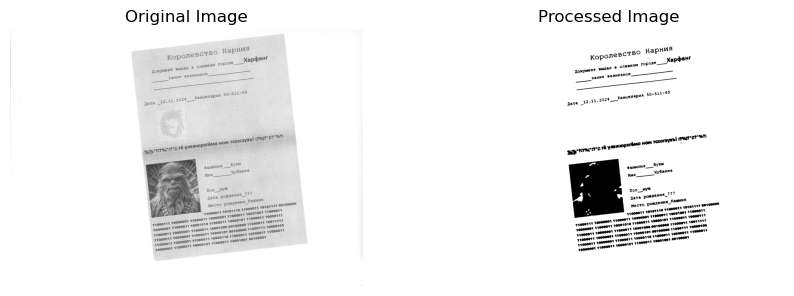

Text from C:\Users\dima2\Desktop\II\1\1.jpg:
Королевство Нарния So-sii-6 Харфант

Processing 2.jpg...
[2024/11/29 15:17:14] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.11781978607177734
[2024/11/29 15:17:15] ppocr DEBUG: rec_res num  : 24, elapsed : 0.5276949405670166


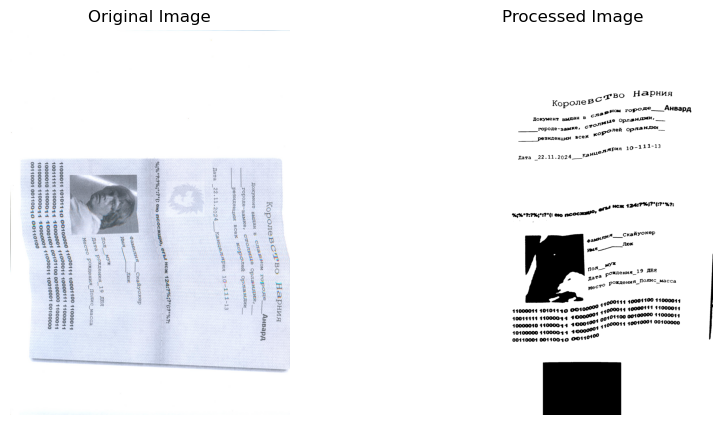

Text from C:\Users\dima2\Desktop\II\1\2.jpg:
dno oooooo o 1a1a22.11:2924 докмэнт тл. ыдан ee. слнм лй ээнэ Слл o--ls рлэ арния шч Анвард

Processing 3.jpg...
[2024/11/29 15:17:24] ppocr DEBUG: dt_boxes num : 60, elapsed : 0.14845585823059082
[2024/11/29 15:17:24] ppocr DEBUG: rec_res num  : 60, elapsed : 0.5254080295562744


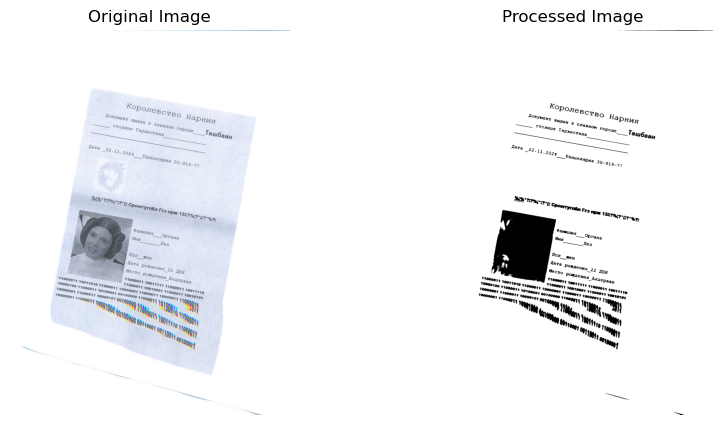

Text from C:\Users\dima2\Desktop\II\1\3.jpg:
Королевство Дюлент арния нган лавнсн гвлише архистанс ашбаан ађа ..р ханцелрид So-ot-z 'h?rot? срсеггглол ггэнри 8r?? ?b? бахлйн гэна ал ађа днин eet. дь рээдния gooо лдеваан osio оооо oi Igodot. Igoog. ооооорч oooo oog Iopoo ooog g. Tonoodr? hoauo р Do D IOo ioboop?

Processing 4.jpg...
[2024/11/29 15:17:33] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.11188697814941406
[2024/11/29 15:17:33] ppocr DEBUG: rec_res num  : 3, elapsed : 0.0969991683959961


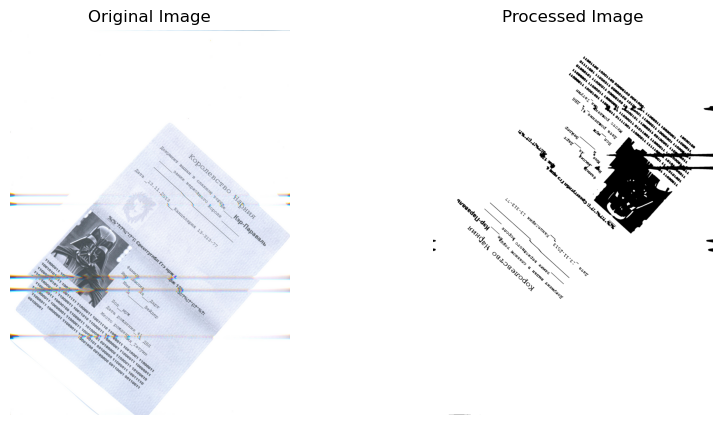

Text from C:\Users\dima2\Desktop\II\1\4.jpg:
Кэp-

Processing 5.jpg...
[2024/11/29 15:17:37] ppocr DEBUG: dt_boxes num : 76, elapsed : 0.9234492778778076
[2024/11/29 15:17:37] ppocr DEBUG: rec_res num  : 76, elapsed : 0.615717887878418


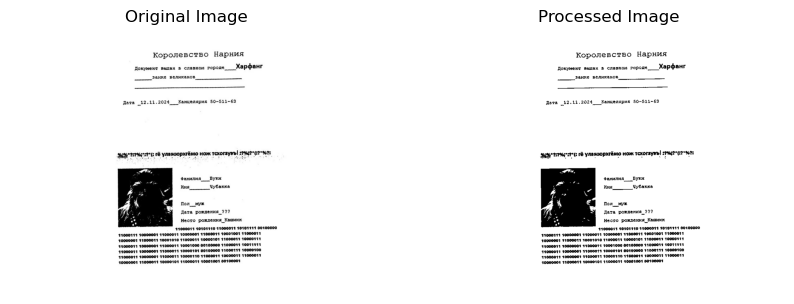

Text from C:\Users\dima2\Desktop\II\1\5.jpg:
оролевство нарния Харфанг документ идан славнм грде амке еликанее дата 12.11,2024 амцелярил oэ1-t: лэжюрхгёмо нож Tcxorayeb! 2o? ti2 o? амилия Еки Чуфакха ол..муж Дата хдения Y?? Necтe дления кшиин oооо и рое оноо Iooouogo ttiggoo. ђонђђ Tootto оооо Toouoot оођ иоо ogooo! оо оооч ооолоођ



In [2]:
import numpy as np
import cv2
import pytesseract
import re
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
import os

# Укажите путь к Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Настройка PaddleOCR с использованием дообученной модели
ocr = PaddleOCR(
    use_angle_cls=False,
    lang="ru",
    rec_model_dir="C:\\Users\\dima2\\Desktop\\II\\rec_custom_model"  # Путь к дообученной модели
)

def get_image_orientation(image_path):
    """
    Определение ориентации изображения с использованием Tesseract.
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    osd = pytesseract.image_to_osd(gray)  # Определение ориентации
    rotation_angle = int(re.search(r'(?<=Rotate: )\d+', osd).group(0))
    return rotation_angle


def correct_image_orientation(image_path):
    """
    Коррекция ориентации изображения на основе данных от Tesseract OCR.
    """
    rotation_angle = get_image_orientation(image_path)
    img = cv2.imread(image_path)
    if rotation_angle != 0:
        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, -rotation_angle, 1.0)
        corrected_img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    else:
        corrected_img = img
    return corrected_img


def preprocess_image(image_path):
    """
    Предобработка изображения: коррекция ориентации, уменьшение шума и бинаризация.
    """
    # Коррекция ориентации
    corrected_img = correct_image_orientation(image_path)

    # Преобразование в оттенки серого
    gray = cv2.cvtColor(corrected_img, cv2.COLOR_BGR2GRAY)

    # Уменьшение шума
    denoised = cv2.fastNlMeansDenoising(gray, None, 30, 7, 21)

    # Бинаризация
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return corrected_img, binary


def recognize_text(image_path):
    """
    Распознавание текста с использованием PaddleOCR с дообученной моделью.
    """
    # Распознавание текста
    result = ocr.ocr(image_path, cls=False)  # Распознавание текста
    recognized_text = " ".join([line[1][0] for line in result[0]])  # Извлечение текста
    return recognized_text


def process_image(image_path, output_dir):
    """
    Обработка изображения, распознавание текста и вывод результатов.
    """
    # Предобработка изображения
    corrected_img, processed_img = preprocess_image(image_path)

    # Распознавание текста
    text = recognize_text(image_path)

    # Вывод оригинального и обработанного изображений
    original_image = cv2.imread(image_path)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Processed Image")
    plt.imshow(processed_img, cmap="gray")
    plt.axis('off')
    plt.show()

    # Сохранение результатов
    output_text_file = os.path.join(output_dir, f"{os.path.basename(image_path)}.txt")
    with open(output_text_file, "w", encoding="utf-8") as f:
        f.write(text)

    print(f"Text from {image_path}:\n{text}\n")
    return text


def main():
    """
    Главная функция для обработки всех изображений в указанной папке.
    """
    input_folder = "C:\\Users\\dima2\\Desktop\\II\\1"  # Папка с тестовыми изображениями
    output_folder = "C:\\Users\\dima2\\Desktop\\II\\output_results"  # Папка для сохранения результатов
    os.makedirs(output_folder, exist_ok=True)

    for image_file in os.listdir(input_folder):
        image_path = os.path.join(input_folder, image_file)
        if image_file.lower().endswith(('png', 'jpg', 'jpeg')):
            print(f"Processing {image_file}...")
            process_image(image_path, output_folder)


if __name__ == "__main__":
    main()

